In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-smart-home-device-efficiency-dataset/smart_home_device_usage_data.csv


In [58]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold 

In [15]:
df= pd.read_csv("/kaggle/input/predict-smart-home-device-efficiency-dataset/smart_home_device_usage_data.csv")
df.head

<bound method NDFrame.head of       UserID       DeviceType  UsageHoursPerDay  EnergyConsumption  \
0          1    Smart Speaker         15.307188           1.961607   
1          2           Camera         19.973343           8.610689   
2          3  Security System         18.911535           2.651777   
3          4           Camera          7.011127           2.341653   
4          5           Camera         22.610684           4.859069   
...      ...              ...               ...                ...   
5398    5399       Thermostat          4.556314           5.871764   
5399    5400           Lights          0.561856           1.555992   
5400    5401    Smart Speaker         11.096236           7.677779   
5401    5402  Security System          8.782169           7.467929   
5402    5403       Thermostat         13.540381           9.043076   

      UserPreferences  MalfunctionIncidents  DeviceAgeMonths  \
0                   1                     4               36   
1

In [16]:
df.duplicated().sum()

0

In [17]:
df.head()

,UserID,DeviceType,UsageHoursPerDay,EnergyConsumption,UserPreferences,MalfunctionIncidents,DeviceAgeMonths,SmartHomeEfficiency
0,1,Smart Speaker,15.307188,1.961607,1,4,36,1
1,2,Camera,19.973343,8.610689,1,0,29,1
2,3,Security System,18.911535,2.651777,1,0,20,1
3,4,Camera,7.011127,2.341653,0,3,15,0
4,5,Camera,22.610684,4.859069,1,3,36,1


In [18]:
df = pd.DataFrame(df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


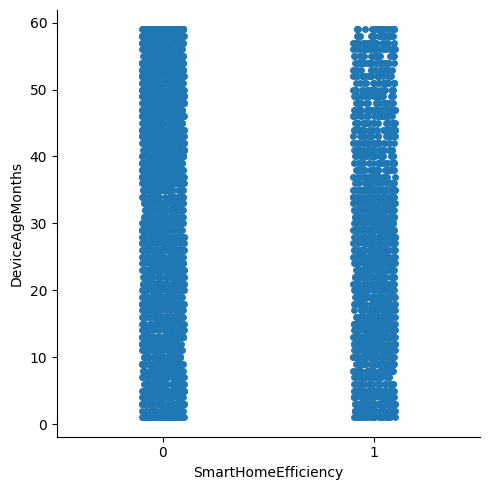

In [19]:
# Convert infinite values to NaN
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
sns.catplot(x = 'SmartHomeEfficiency', y ='DeviceAgeMonths', data=df, kind="strip")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


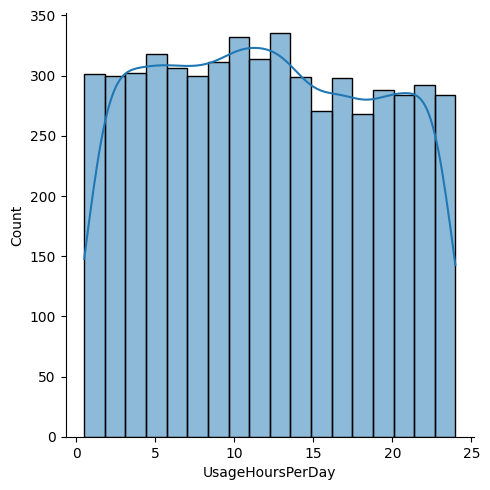

In [20]:
sns.displot(df['UsageHoursPerDay'], kde=True)

In [21]:
X = df.drop(['SmartHomeEfficiency'], axis=1)
y = df['SmartHomeEfficiency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test.drop('DeviceType', axis=1, inplace=True)
X_train.drop('DeviceType',axis=1, inplace=True)
initial_features = list(X_test.columns)

In [ ]:
from matplotlib.ticker import MaxNLocator
_, axs = plt.subplots(3, 3,figsize=(12,12))
for col, ax in zip(initial_features, axs.ravel()):
    vc= X_train[col].value_counts() / len(X_train)
    ax.bar(vc.index, vc)
    vc = X_test[col].value_counts() / len(X_test)
    ax.bar(vc.index, vc, alpha=0.6)
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()
print(X_train.head())

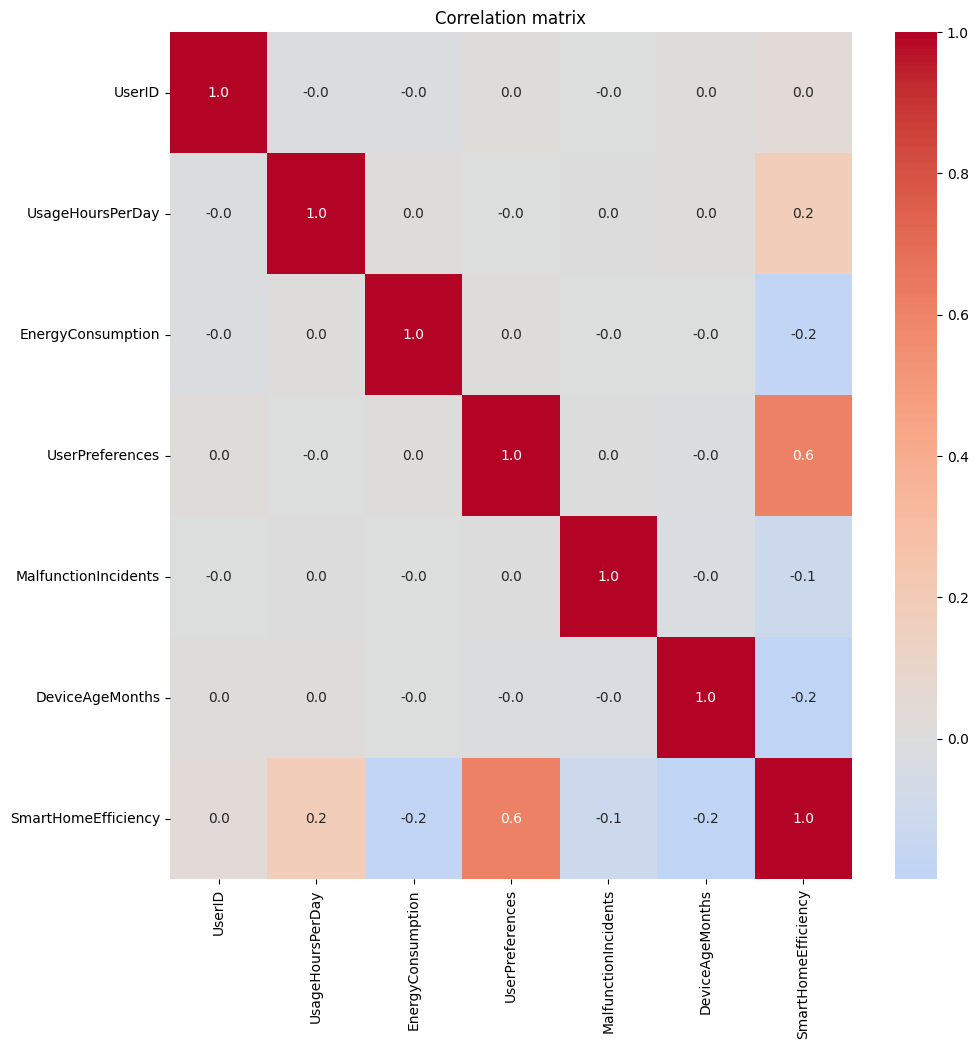

In [23]:

# Add the target variable to the training data for correlation calculation
X_train_with_target = X_train.copy()
X_train_with_target['SmartHomeEfficiency'] = y_train

# Convert all columns to numeric values, forcing conversion and setting errors='coerce' to handle non-numeric data
X_train_with_target = X_train_with_target.apply(pd.to_numeric, errors='coerce')
# Define the features to include in the correlation calculation
corr_features = initial_features + ['SmartHomeEfficiency']

# Calculate the correlation matrix
cc = np.corrcoef(X_train_with_target[corr_features].T)

# Plot the correlation matrix
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f', 
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()


In [24]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
# Fill NaNs with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)
nan_counts = X_train.isna().sum()
print(nan_counts)

UserID                  0
UsageHoursPerDay        0
EnergyConsumption       0
UserPreferences         0
MalfunctionIncidents    0
DeviceAgeMonths         0
dtype: int64


2024-06-24 01:57:01.426652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 01:57:01.426781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 01:57:01.589536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


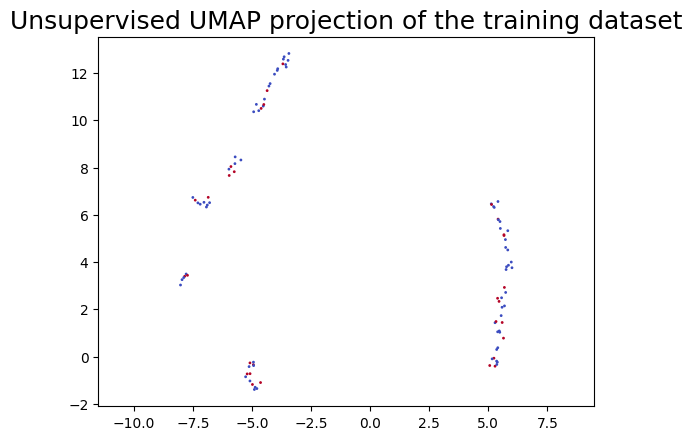

In [25]:
import umap
def plot_embedding(embedding, target, title):
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=target,
        cmap='coolwarm'
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=18)
    plt.show()

train_sample = X_train_with_target.sample(100)  # Adjust the sampling size as needed
reducer = umap.UMAP()
plot_embedding(reducer.fit_transform(train_sample[initial_features]),
               train_sample['SmartHomeEfficiency'],  # Replace 'target_column' with your actual target column name
               'Unsupervised UMAP projection of the training dataset')

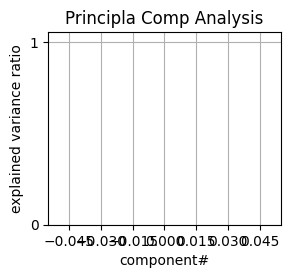

[0.9998577]
Principal Component 1 has the highest variance explained.
[[-2020.18822771]
 [-1639.19474382]
 [ 1463.81008667]
 ...
 [-1539.19655969]
 [  970.8065216 ]
 [-2495.19259842]]


In [26]:

# Initialize PCA with 1 component (PC1)
pca = PCA(n_components=1)
pca.fit(X_train[initial_features])
plt.figure(figsize=(3, 2.5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator())
plt.title('Principla Comp Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks(np.arange(0, 1.1, step=0.1))  # Ensure y-ticks are in the range [0, 1]
plt.grid(True)
plt.yticks([0,1])
plt.show()
X_train_pca = pca.transform(X_train)
# Assuming pca is already fitted
explained_variance_ratios = pca.explained_variance_ratio_

# Print or inspect the ratios
print(explained_variance_ratios)

# Identify the component with the highest variance explained
highest_variance_index = np.argmax(explained_variance_ratios)
print(f"Principal Component {highest_variance_index + 1} has the highest variance explained.")
print(X_train_pca)

In [56]:

kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cross_validate(model, label, features=initial_features, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    
    If n_repeats > 1, the model is trained several times with different seeds.
    """
    start_time = datetime.datetime.now()
    scores = []
    
    # Initialize oof as an empty dictionary or DataFrame
    oof, test_pred = {}, {}
    
    # Ensure oof_preds is initialized correctly as DataFrame or Series
    oof_preds = pd.Series(np.nan, index=X_train_with_target.index)
    
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X_train_with_target)):
        X_tr = X_train_with_target.iloc[idx_tr][features]
        X_va = X_train_with_target.iloc[idx_va][features]
        y_tr = X_train_with_target.iloc[idx_tr]['SmartHomeEfficiency']
        y_va = X_train_with_target.iloc[idx_va]['SmartHomeEfficiency']
        
        y_pred = np.zeros_like(y_va, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats
        
        score = r2_score(y_va, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}")
        scores.append(score)
        
        # Assign predictions to correct indices in oof_preds
        oof_preds.iloc[idx_va] = y_pred
        
        # Check for SINGLE_FOLD and break if necessary
        if 'SINGLE_FOLD' in globals() and SINGLE_FOLD:
            break
    
    elapsed_time = datetime.datetime.now() - start_time
    if 'SINGLE_FOLD' in globals() and SINGLE_FOLD:
        fold_str = ' single fold'
    else:
        fold_str = ''
    print(f"# Overall: {np.array(scores).mean():.5f} {label}{fold_str}   {int(np.round(elapsed_time.total_seconds() / 60))} min")
    
    # Store out-of-fold predictions
    oof[label] = oof_preds
    
    if COMPUTE_TEST_PRED:
        # Compute test predictions
        test_preds = np.zeros(len(X_test), dtype=float)
        X_tr = X_train_with_target[features]
        y_tr = X_train_with_target['SmartHomeEfficiency']
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            test_preds += m.predict(X_test[features])
        test_preds /= n_repeats
        
        # Store test predictions
        test_pred[label] = test_preds

In [28]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
binary_cols = ['UserPreferences']
numerical_cols = ['UsageHoursPerDay', 'EnergyConsumption', 'MalfunctionIncidents', 'DeviceAgeMonths']

onehot_transformer = OneHotEncoder(drop='first', sparse = False)
scaler = StandardScaler()

In [29]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
transformers = [
    ('binary', onehot_transformer, binary_cols),
    ('scaler', scaler, numerical_cols)
])

In [30]:
classifier = RandomForestClassifier(n_estimators = 100,random_state =0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
pipeline.fit(X_train, y_train)

accuracy = pipeline.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model accuracy: 0.95


In [59]:
import xgboost
import datetime
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
# XGBoost
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 100, 'learning_rate': 0.2639887908316703, 'max_depth': 10, 'reg_lambda': 62.46661785864016, 'min_child_weight': 0.33652299514909034, 'colsample_bytree': 0.2319730052165745, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_bin': 2048, 'gamma': 0} # 0.83868
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost')



# Fold 0: R2=0.50595
# Fold 1: R2=0.56430
# Fold 2: R2=0.55138
# Fold 3: R2=0.50676
# Fold 4: R2=0.54680
# Overall: 0.53504 XGBoost   0 min


In [24]:
from sklearn.linear_model import Ridge
import warnings
model = make_pipeline(OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                      StandardScaler(),
                      Ridge())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    cross_validate(model, 'Ridge one-hot', features=initial_features)

# Fold 0: R2=0.18649
# Fold 1: R2=0.19358
# Fold 2: R2=0.18558
# Fold 3: R2=0.18474
# Fold 4: R2=0.19688
# Overall: 0.18946 Ridge one-hot   0 min


NameError: name 'COMPUTE_TEST_PRED' is not defined

In [66]:
from sklearn.linear_model import Ridge, LinearRegression
import catboost
model = make_pipeline(StandardScaler(),
                      LinearRegression())
COMPUTE_TEST_PRED = True
cross_validate(model, 'LinearRegression')

model = make_pipeline(StandardScaler(),
                      PolynomialFeatures(degree=2),
                      Ridge())
cross_validate(model, 'Poly-Ridge')

model = make_pipeline(StandardScaler(),
                      SplineTransformer(),
                      Ridge())
cross_validate(model, 'Spline-Ridge')
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost sorted', initial_features)

# Fold 0: R2=0.46916
# Fold 1: R2=0.51830
# Fold 2: R2=0.50973
# Fold 3: R2=0.47348
# Fold 4: R2=0.51912
# Overall: 0.49796 LinearRegression   0 min
# Fold 0: R2=0.58837
# Fold 1: R2=0.59760
# Fold 2: R2=0.60732
# Fold 3: R2=0.55617
# Fold 4: R2=0.60257
# Overall: 0.59041 Poly-Ridge   0 min
# Fold 0: R2=0.51888
# Fold 1: R2=0.57539
# Fold 2: R2=0.55582
# Fold 3: R2=0.50719
# Fold 4: R2=0.56286
# Overall: 0.54403 Spline-Ridge   0 min
# Fold 0: R2=0.87237
# Fold 1: R2=0.87770
# Fold 2: R2=0.90134
# Fold 3: R2=0.83588
# Fold 4: R2=0.87269
# Overall: 0.87200 CatBoost sorted   0 min
